<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#2.-Chemical-equilibrium:-Magnetization-flows-through-chemical-exchange" data-toc-modified-id="2.-Chemical-equilibrium:-Magnetization-flows-through-chemical-exchange-1">2. Chemical equilibrium: Magnetization flows through chemical exchange</a></span></li><li><span><a href="#2.1-Simulating-Titration-Curves" data-toc-modified-id="2.1-Simulating-Titration-Curves-2">2.1 Simulating Titration Curves</a></span></li><li><span><a href="#2.2-Effect-of-chemical-exchange-on-line-width" data-toc-modified-id="2.2-Effect-of-chemical-exchange-on-line-width-3">2.2 Effect of chemical exchange on line width</a></span></li></ul></div>

# modelling a chemical equilibrium

In [2]:
import numpy as np
from scipy import linalg # Import the linear algebra module
import matplotlib.pyplot as plt
%matplotlib notebook

from SpinEq import Eq # Import the equilibrium modelling software
import spike # Import the NMR data processing sofware
import spike.NPKData as npk
from spike.File import BrukerNMR as bk

# The function below computes a synthetic FID
def gen_fid(TD=2048, dt = 250E-6, noise = 10., res_list = [], K = [], all_freq = True):
    ''' Create a synthetic FID from a list of resonances and acquisition parameters
        TD time domain number of points
        dt dwell time in seconds
        noise : level of noise  # Not implemented
        res_list : a list of resonances [I, W, R2] where I is the intensity, W the pulsation and R2 the transverse
                   relaxation rate.
        K is an exchange matrix between the resonances
        all_freq : if true, all components of the signal are summed up
    '''
    
    # Handle resonances, Build a diagonal matrix containing the frequencies and the damping factors
    NS = len(res_list)        # Number of signals (resonances)
    rlm = np.array(res_list)  # Convert the resonance list into array (for vector calculations)
    VR2 = rlm[:,2]            # Vector of transverse relaxation rates
    VW = rlm[:,1]             # Vector of frequencies (pulsations in rad.s-1)
    VI = np.matrix(rlm[:,0])  # Vector of intensities
    B = -VR2-1j*VW            # Vector of exponential factors (damping + pulsation)
    K = np.matrix(K)          # Matrix of chemical exchange rates (is s-1)
    
    MB = np.diag(B)            # The elements of B vector are the diagonal elements of a matrix
    if (MB.size == K.size):    # If the size of the BN matrix matches the size of the exchange matrix
        A = MB + K             # Then the exponential factor is a matrix that contains off diagonal terms
        DA, W = np.linalg.eig(A)       # Diagonalize the matrix
    else:
        DA = B                 # If not the exponential factor is a diagonal matrix
    
    # Build the FID
    time = np.arange(TD)*dt   # Build the time sampling vector
    FID = np.zeros((NS,TD),dtype=complex)
    for i,t in enumerate(time):            # Build the time evolution of transverse magnetization
        temp = np.exp(DA*t)*VI.T
        FID[:,i] =  temp.T                 # lines of the FID array contain the different frequency
                                           # and columns the sampled points
        
        
    if all_freq:     
        FID = np.cumsum(FID,axis = 0)      # sum up the different frequency contributions to a single FID
        FID = FID[-1,:]
    return FID



    Welcome to the Spineq program,  version 4 Apr 2017

    Licence : Cecill 2.0
    Authors : Marc-Andre Delsuc <madelsuc@unistra.fr> and Bruno Kieffer <kieffer@igbmc.fr>
    
    check examples.py for help
    

          SPIKE
    Version     : 0.99.9
    Date        : 02-05-2019
    Revision Id : 409
*** zoom3D not loaded because of an error ***
plugins loaded:
Bruker_NMR_FT,  Bucketing,  FTMS_calib,  Fitter,  Integrate,  Linear_prediction,  PALMA,  Peaks,  apmin,  bcorr,  bokeh_display,  fastclean,  gaussenh,  pg_sane,  rem_ridge,  sane,  sg,  test,  urQRd,  wavelet, 

spike.plugins.report() for a short description of each plugins
spike.plugins.report('module_name') for complete documentation on one plugin


## 2. Chemical equilibrium: Magnetization flows through chemical exchange

Using the numerical object describing a flow, we will use the spineq framework to simulate the flows of molecules that interact non-covalently together (weak interactions). The equilibrium.ipynb notebook contains an example of an interaction between a ligand (a polyproline peptide) that interacts with a protein domain (a SH3 domain). In the example shown below, the dissociation equilibrium constant is set to 50 µM and the kinetic constant of the complex formation $k_{on}$ is set to $10^8$  $s^{-1}M^{-1}$. The total concentration of the protein is 20 µM.

The fonction EL_eq() below enables the calculation of chemical flows for given equilibrium constants and total concentrations of ligand (Ltot) and receptors (Etot).


In [3]:
# The following function describes a 1:1 equilibrium
def EL_eq(Keq=1/150e-6, Ltot=1e-3, Etot=20e-6,k_on=1e8):
    # E + L <> EL
    eq1 = Eq(Species=["E","L","EL"])
    eq1.diffusion = k_on
    L=0; E=1; EL=2           # Symbolic names are given to each specie (3) that are present in solution
    # We set a chemical equilibrium with 3 sites and two chemicals 
    eq1.set_K3(Keq, L, E, EL , kon = k_on)           # 
    eq1.set_massconserv(Ltot, [1,0,1])  # Connect species L and EL
    eq1.set_massconserv(Etot, [0,1,1])  # Connect species E and EL
    eq1.set_concentration(Ltot, L)      # Set the total ligand concentration L0
    eq1.set_concentration(Etot, E)      # Set the total ligand concentration E0
    #####
    #eq1.report()  # Report the initial flow network
    eq1.solve()   # Integration of the system
    cf = eq1.get_concentration_array()
    kf = np.array([f.k for f in eq1.kinlist])
    return [cf,kf]   # Return both the vector of concentrations and the flow rates

## 2.1 Simulating Titration Curves

The following script computes the equilibrium concentrations during a titration experiment where the total ligand concentrations vary between 10 µM and 0.5 mM.


<IPython.core.display.Javascript object>


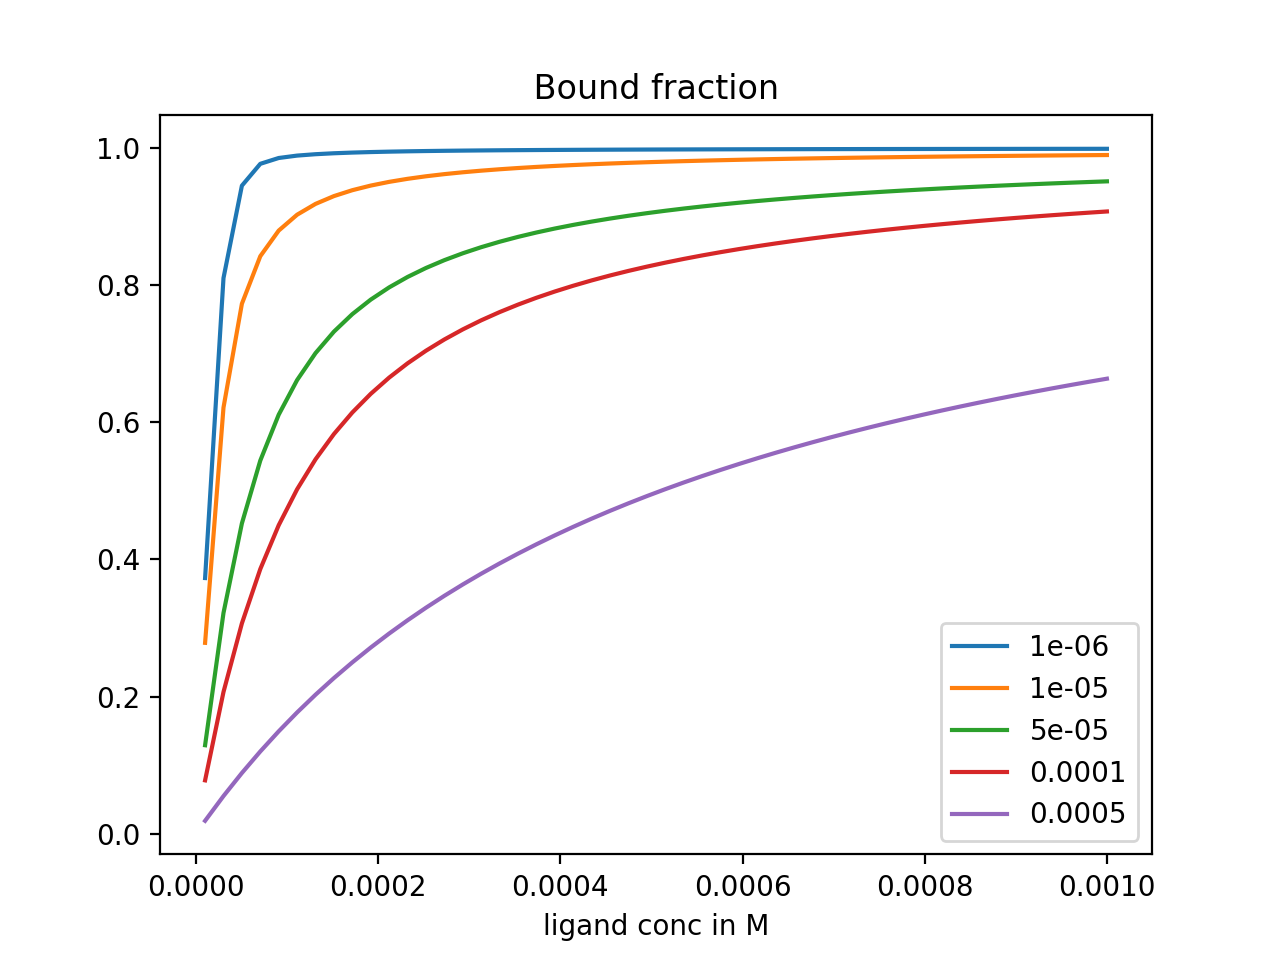

In [4]:
# Titration curves simulated for a unique protein binding site with several dissociation equilibrium constants (Kd)
L=0; E=1; EL=2
# Create a vector of total ligand concentrations
L0 = np.linspace(1e-5,1e-3,50)
# Loop on different Kd values
for Kd in [0.000001,0.00001,0.00005, 0.0001, 0.0005]:
    conc = np.array([EL_eq(Keq=1/Kd,Ltot=l,Etot=20e-6)[0] for l in L0])
    # Computes the bound fraction
    Eocc = conc[:,EL]/(conc[:,E]+conc[:,EL])
    plt.plot(L0,Eocc, label=str(Kd))
plt.title(" Bound fraction " )
plt.xlabel("ligand conc in M")
plt.legend()
plt.show()


## 2.2 Effect of chemical exchange on line width

The equilibrium between the ligand in the free (L) and bound (EL) states as well as the receptor in the free (E) and bound states (EL) corresponds to a balance of the association and dissociation flows. These flows are determined by the kinetic constants kon and koff as well as the concentrations of different species. The same equilibrium state (therefore identical concentrations of the 3 species (E, L, EL) may correspond to different association and dissociation flows. The dynamical behaviour of the system has direct repercussions on the width of the observed NMR lines (those ligand or protein).

In the example shown below, we study the interaction between a protein and a peptide. The peptide has a non-natural amino-acid that contains a fluorine atom that is measured by fluorine NMR.

<IPython.core.display.Javascript object>


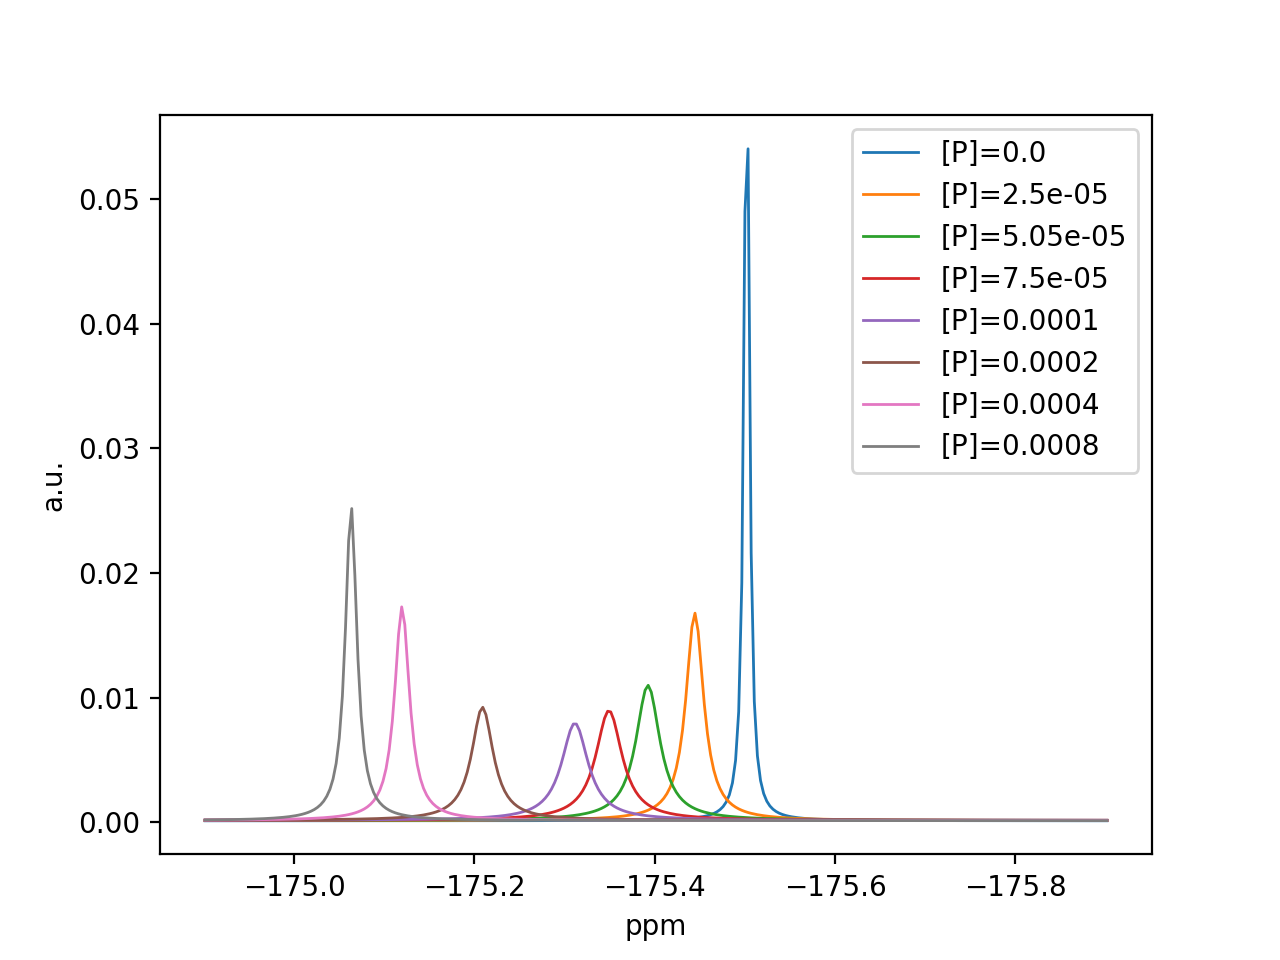

/Users/mad/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [9]:
# Titration experiment from the ligand point of view
E0 = [0., 25e-6, 50.5e-6, 75e-6, 100e-6, 200.0e-6, 400e-6, 800e-6]  # A list of protein concentrations
L0 = 100E-6     # Fixed concentration of the fluorinated peptide
L=0; E=1; EL=2 

# Equilibrium thermodynamic and kinetic parameters
Kd = 100E-6 # M
kon = 1.0e8

# Spectroscopic parameters
nu0 = 564.7 # 19F carrier Freq in MHz (center of the spectrum)
ppm0 = -175 #  Referencing : chemichal shift at the midle of the spectrum
dw = 250E-6 #  Sampling dwell time in s

L_ppm = -175.5   # Chemical shift of the ligand signal in the free form
L_R2 = 4.*np.pi # s-1
L_w = nu0*(ppm0-L_ppm)*2*np.pi # Pulsation in the rotating frame

EL_ppm = -175.0  # Chemical shift of the ligand signal in the complex
EL_R2 = 8.0*np.pi # s-1
EL_w = nu0*(ppm0-EL_ppm)*2*np.pi # Pulsation in the rotating frame
M0 = 1. # Magnetization

R_spectra = []   # This list will contain the processed spectra

# Computes the spectrum for each titration point
for i,e0 in enumerate(E0):
    
    # Compute equilibrium state
    eq = EL_eq(Keq=1/Kd, Ltot=L0, Etot=e0, k_on = kon)

    # Build exchange matrix for Ligand
    ka = eq[1][0]*eq[0][E]     # Rate of association (kon*E)
    kd = eq[1][1]              # Rate of dissociation (koff)
    exc =[[-ka,kd],[ka,-kd]]   # The exchange matrix

    # Build the list of resonances (one fluorine signal, two states (free and bound))
    resonances=[[eq[0][L]*M0,L_w,L_R2],[eq[0][EL]*M0,EL_w,EL_R2]]
    fid = gen_fid(TD=2048,dt = dw, res_list=resonances, K=exc, all_freq = True )
    
    # Convert the synthetic fid into a Spike object for NMR processing
    d = npk.NPKData(buffer = fid)
    d.axis1.specwidth = 1/dw
    d.axis1.frequency = nu0
    d.axis1.offset = nu0*ppm0 - 1/(2*dw)# Defines the right-hand frequency
    d.unit = 'ppm'
    ft = d.copy().ft_sim().real()    # Perform the Fourier transform and take the real part
    R_spectra.append(ft)
    
    label = '[P]='+str(e0)
    if i == 0 :
        ft.display(zoom=(-174.9,-175.9), label=label) 
    else :
        ft.display(zoom=(-174.9,-175.9), new_fig=False, label=label)


PP: 1 detected
PP: 1 detected
PP: 1 detected
PP: 1 detected
PP: 1 detected
PP: 1 detected
PP: 1 detected
PP: 1 detected


<IPython.core.display.Javascript object>


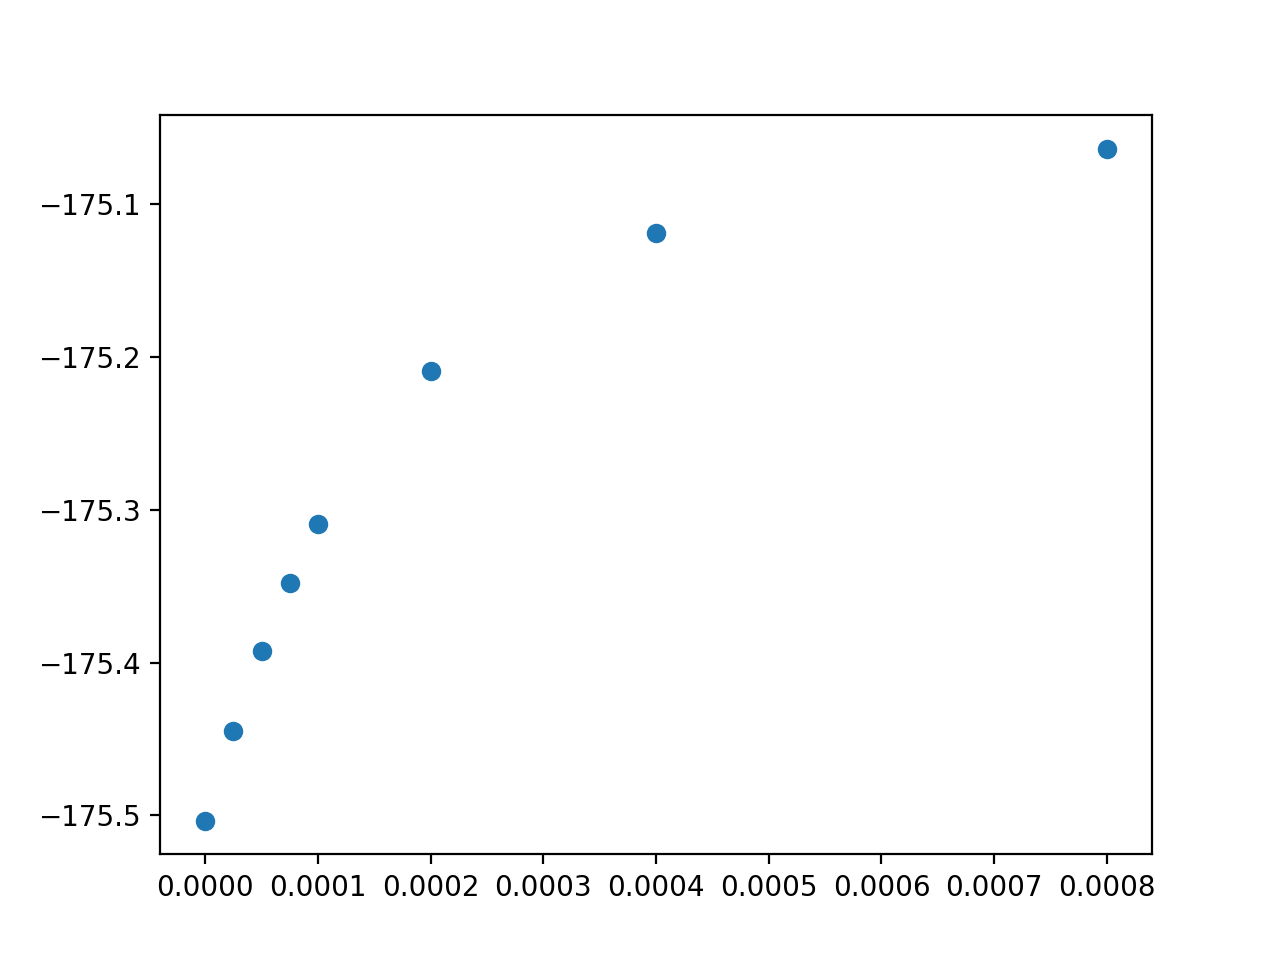

In [10]:
# Plot the frequency of the fluorine peak as a function of the protein concentration
frequency = []
for ft in R_spectra: # For all spectra
    ft.pp(threshold=0.001)  # perform a peak-picking
    frequency.append(ft.axis1.itop(ft.peaks[0].pos)) # Get the position of the unique peak in ppm
plt.figure()
plt.plot(E0,frequency,'o')